# Dataset Model Comparison

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Get the dataset

Dataset Information:
X: (10000, 784), [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189

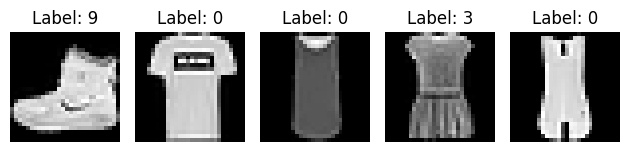

Updated Dataset Information:
X: (10000, 1555), [0. 1.]
y: (10000,), ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml


# Generate the dataset with specified parameters
fashion_mnist = fetch_openml(
    "Fashion-MNIST", version=1, as_frame=False, parser="liac-arff"
)
N = 10000  # Number of samples to use
X_data, y_data = fashion_mnist.data[:N], fashion_mnist.target[:N]

# Display dataset information
print("Dataset Information:")
print(f"X: {X_data.shape}, {np.unique(X_data)}")
print(f"y: {y_data.shape}, {np.unique(y_data)}")

# Plot 5 sample images from the dataset
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_data[i].reshape(28, 28), cmap="gray")  # Fashion-MNIST images are 28x28
    plt.title(f"Label: {y_data[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Convert the dataset to binary classification
X_data = (X_data / 16).astype(np.uint8)

# Downsample to 16x16
X_data = X_data.reshape(N, 28, 28)[:, ::2, ::2]

# Reshape X_data to be 2D (n_samples, n_features) for OneHotEncoder
# Each of the 14*14 = 196 pixels will be treated as a categorical feature.
X_data_reshaped = X_data.reshape(N, -1)

# Convert the dataset to binary classification
encoder = OneHotEncoder(sparse_output=False, max_categories=8)
X_data = encoder.fit_transform(X_data_reshaped)

# Display the updated dataset information
print("Updated Dataset Information:")
print(f"X: {X_data.shape}, {np.unique(X_data)}")
print(f"y: {y_data.shape}, {np.unique(y_data)}")

# Split the dataset into training and testing sets
X_train_np, X_test_np, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# Convert NumPy arrays to Pandas DataFrames
feature_names = [f"feature_{i}" for i in range(X_data.shape[1])]
X_train = pd.DataFrame(X_train_np, columns=feature_names)
X_test = pd.DataFrame(X_test_np, columns=feature_names)

## Evaluate the models

In [3]:
import pickle
from time import perf_counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


def evaluate_model(model, X_train, y_train, X_test, y_test, name=None):
    # Fit the model
    start_time = perf_counter()
    model.fit(X_train, y_train)
    training_time = perf_counter() - start_time

    # Estimate the model size
    model_size = None
    try:
        if name in (
            "Green Tsetlin Classifier",
            "Green Tsetlin Sparse Classifier",
            "C Tsetlin Classifier",
            "GridSearch C Tsetlin Classifier",
        ):
            if isinstance(model, GridSearchCV):
                model_size = model.best_estimator_.estimate_model_size()
            else:
                model_size = model.estimate_model_size()
        else:
            pickled_model = pickle.dumps(model)
            model_size = len(pickled_model)
    except Exception:
        pass

    # Predict on the training set
    start_time = perf_counter()
    y_train_pred = model.predict(X_train)
    prediction_train_time = perf_counter() - start_time

    # Predict on the test set
    start_time = perf_counter()
    y_test_pred = model.predict(X_test)
    prediction_test_time = perf_counter() - start_time

    # Calculate Accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Model: {name}")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")

    if isinstance(model, GridSearchCV):
        print(f"Best parameters for {name}: \n  {model.best_params_}")

    return (
        name,
        train_accuracy,
        test_accuracy,
        training_time,
        prediction_train_time,
        prediction_test_time,
        model_size,
    )

In [4]:
from sklearn.svm import SVC
from tsetlin_machine_py.green_tsetlin_clf import GreenTsetlinClassifier
from tsetlin_machine_py.c_tsetlin_clf import CTsetlinClassifier

models = [(SVC(random_state=42), "SVC")]

# Green Tsetlin Classifier
green_tsetlin_clf = GreenTsetlinClassifier(random_state=42)
models.append((green_tsetlin_clf, "Green Tsetlin Classifier"))

# C Tsetlin Classifier
c_tsetlin_clf = CTsetlinClassifier(num_clauses=100, random_state=42)
models.append((c_tsetlin_clf, "C Tsetlin Classifier"))

# Evaluate each model
results_table = PrettyTable()
results_table.field_names = [
    "Model",
    "Training Accuracy",
    "Test Accuracy",
    "Training Time (s)",
    "Prediction Train Time (s)",
    "Prediction Test Time (s)",
    "Model Size (bytes)",
]
for i, (model, name) in enumerate(models):
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test, name=name)
    results_table.add_row(
        [
            metrics[0],
            f"{metrics[1]:.4f}",
            f"{metrics[2]:.4f}",
            f"{metrics[3]:.4f}",
            f"{metrics[4]:.4f}",
            f"{metrics[5]:.4f}",
            f"{metrics[6]:,}" if metrics[6] else "N/A",
        ]
    )
    print(f"  Evaluated {i + 1}/{len(models)}: {name}")

Model: SVC
  Training Accuracy: 0.9329
  Test Accuracy: 0.8260
  Evaluated 1/3: SVC
Model: Green Tsetlin Classifier
  Training Accuracy: 0.7917
  Test Accuracy: 0.7620
  Evaluated 2/3: Green Tsetlin Classifier
Model: C Tsetlin Classifier
  Training Accuracy: 0.7652
  Test Accuracy: 0.7530
  Evaluated 3/3: C Tsetlin Classifier


In [5]:
# Display the results table
results_table.sortby = "Test Accuracy"
results_table.reversesort = True
# print(results_table)

# Get data from PrettyTable
columns = results_table.field_names
data = results_table.rows

# Create Pandas DataFrame
df = pd.DataFrame(data, columns=columns)
display(df)

,Model,Training Accuracy,Test Accuracy,Training Time (s),Prediction Train Time (s),Prediction Test Time (s),Model Size (bytes)
0,SVC,0.9329,0.8260,6.8504,28.4580,7.0930,"66,885,009"
1,Green Tsetlin Classifier,0.7917,0.7620,15.4220,0.0396,0.0117,"3,124,040"
2,C Tsetlin Classifier,0.7652,0.7530,21.5637,0.6618,0.1638,"316,140"
